In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn import metrics
import seaborn as sb
from sklearn.metrics import mean_squared_error as mse 
from tqdm import tqdm



C:\Users\Fabrizio\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('C:/Users/Fabrizio/Desktop/datasets_ML/airbnb.csv')

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.683710,-73.964610,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,...,2023-05-01,0.24,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,...,2023-12-18,1.67,1,343,6,Exempt,4.17,1,2,1
3,3857863,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.835600,-73.942500,Private room,120.0,...,2023-09-17,1.38,2,363,12,No License,4.64,1,1,1
4,40896611,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.751120,-73.978600,Entire home/apt,85.0,...,2023-12-03,0.24,133,335,3,No License,4.91,Studio,1,1


In [3]:
df.shape

(20758, 22)

In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license', 'rating',
       'bedrooms', 'beds', 'baths'],
      dtype='object')

In [5]:
df.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
license                           0
rating                            0
bedrooms                          0
beds                              0
baths                             0
dtype: int64

Let's drop features which are not useful for the price prediction:

In [6]:
df = df.drop(columns = ['id', 'name', 'host_id', 'host_name','latitude', 'longitude','license','neighbourhood'])

In [7]:
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths
0,Brooklyn,Private room,55.0,30,3,2015-12-20,0.03,1,0,0,5.0,1,1,Not specified
1,Manhattan,Entire home/apt,144.0,30,9,2023-05-01,0.24,139,364,2,4.67,2,1,1
2,Manhattan,Entire home/apt,187.0,2,6,2023-12-18,1.67,1,343,6,4.17,1,2,1
3,Manhattan,Private room,120.0,30,156,2023-09-17,1.38,2,363,12,4.64,1,1,1
4,Manhattan,Entire home/apt,85.0,30,11,2023-12-03,0.24,133,335,3,4.91,Studio,1,1


In [8]:
for col in df.columns:
    
    if(df[col].dtypes == 'object'):
        print(col)

neighbourhood_group
room_type
last_review
rating
bedrooms
baths


The features rating, bedrooms, baths should be numeric but they aren't. let's check why:

In [9]:
df['bedrooms'].unique()

array(['1', '2', 'Studio', '3', '6', '5', '4', '7', '15', '9', '8', '14'],
      dtype=object)

The category Studio is included in number of bedrooms. Let's try to put it arbitrarely to a numeric value which makes sense given the typical squared meters of a Studio: between one bedroom and two bedroom apartment.

In [10]:
df.loc[df['bedrooms'] == 'Studio', 'bedrooms'] = 1.5

In [11]:
df['bedrooms'] = df['bedrooms'].astype(float)

In [12]:
df['bedrooms'].unique()

array([ 1. ,  2. ,  1.5,  3. ,  6. ,  5. ,  4. ,  7. , 15. ,  9. ,  8. ,
       14. ])

In [13]:
df['baths'].unique()

array(['Not specified', '1', '2', '1.5', '3', '4', '3.5', '0', '2.5', '5',
       '4.5', '6', '5.5', '11.5', '6.5', '7', '15.5'], dtype=object)

In [14]:
(df['baths']=='Not specified').sum()

13

Sometimes number of bathrooms is not specified. Since this is a very rare event, let's just drop the cases where this happen from our dataset:

In [15]:
to_be_deleted_indices = df.loc[df['baths']=='Not specified'].index

In [16]:
df.drop(to_be_deleted_indices, inplace=True)

df.reset_index(drop=True, inplace=True)

In [17]:
(df['baths']=='Not specified').sum()

0

In [18]:
df['baths'] = df['baths'].astype(float)

In [19]:
df['rating'].unique()


array(['4.67 ', '4.17 ', '4.64 ', '4.91 ', '5.0 ', '4.33 ', '4.50 ',
       '4.79 ', 'No rating', '4.71 ', '3.20 ', '4.80 ', '4.65 ', '4.75 ',
       '4.89 ', '4.43 ', '4.82 ', '4.69 ', '4.11 ', '4.90 ', '4.74 ',
       '4.87 ', '3.67 ', '4.94 ', '4.66 ', '4.58 ', '4.95 ', '4.78 ',
       '4.83 ', '4.73 ', '4.53 ', '4.15 ', '4.45 ', '4.46 ', '4.86 ',
       '4.42 ', '4.81 ', '3.84 ', '4.27 ', '4.21 ', '4.93 ', '4.61 ',
       '4.77 ', '4.40 ', '4.76 ', '4.70 ', '4.60 ', '4.96 ', '4.56 ',
       '3.60 ', '3.0 ', '3.82 ', '4.92 ', '4.85 ', '4.0 ', '4.97 ',
       '4.63 ', '4.38 ', '4.72 ', '4.25 ', '4.68 ', '4.99 ', '4.20 ',
       '4.54 ', '4.88 ', '4.59 ', '4.57 ', '4.18 ', '4.62 ', 'New ',
       '4.98 ', '3.33 ', '4.29 ', '3.40 ', '4.44 ', '4.36 ', '3.75 ',
       '4.22 ', '4.55 ', '4.26 ', '3.92 ', '4.30 ', '4.12 ', '4.06 ',
       '4.51 ', '2.33 ', '4.84 ', '4.47 ', '4.39 ', '4.41 ', '4.35 ',
       '3.88 ', '3.86 ', '4.07 ', '4.52 ', '4.49 ', '4.23 ', '4.31 ',
       '4.13 ', '3.5

In [20]:
(df['rating']=='No rating').sum()

3589

The number of apartment without rating, instead, is too high to drop all these cases. let's try 2 strategies:


1) Replace the missing values with the mean of all ratings

2) Apply KNN to infer the missing values based on the other predictions

First, let's use one hot encoder for the categorical variables

In [21]:
df['neighbourhood_group'].unique().shape

(5,)

In [22]:
encoded_columns = pd.get_dummies(df['neighbourhood_group'], prefix='encoded')

# Add the encoded columns to the dataset
df = pd.concat([df, encoded_columns], axis=1)

# Drop the original column
df.drop(columns=['neighbourhood_group'], inplace=True)

df.head()

,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths,encoded_Bronx,encoded_Brooklyn,encoded_Manhattan,encoded_Queens,encoded_Staten Island
0,Entire home/apt,144.0,30,9,2023-05-01,0.24,139,364,2,4.67,2.0,1,1.0,0,0,1,0,0
1,Entire home/apt,187.0,2,6,2023-12-18,1.67,1,343,6,4.17,1.0,2,1.0,0,0,1,0,0
2,Private room,120.0,30,156,2023-09-17,1.38,2,363,12,4.64,1.0,1,1.0,0,0,1,0,0
3,Entire home/apt,85.0,30,11,2023-12-03,0.24,133,335,3,4.91,1.5,1,1.0,0,0,1,0,0
4,Entire home/apt,115.0,30,5,2023-07-29,0.16,139,276,2,5.0,1.0,1,1.0,0,0,1,0,0


For the room type we can use label encoder, giving increasing values for increasing room quality:

In [23]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [24]:
encoded_dictionary = {'Shared room' : 0 , 'Private room':1, 'Hotel room':2, 'Entire home/apt':3}

In [25]:
df['room_type'] = df['room_type'].replace(encoded_dictionary)

Finally, we split the date of last review into 3 columns for year, month and day

In [26]:
df['last_review'] = pd.to_datetime(df['last_review'])

df['year'] = df['last_review'].dt.year
df['month'] = df['last_review'].dt.month
df['day'] = df['last_review'].dt.day

df.drop(columns=['last_review'], inplace=True)

df.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,baths,encoded_Bronx,encoded_Brooklyn,encoded_Manhattan,encoded_Queens,encoded_Staten Island,year,month,day
0,3,144.0,30,9,0.24,139,364,2,4.67,2.0,1,1.0,0,0,1,0,0,2023,5,1
1,3,187.0,2,6,1.67,1,343,6,4.17,1.0,2,1.0,0,0,1,0,0,2023,12,18
2,1,120.0,30,156,1.38,2,363,12,4.64,1.0,1,1.0,0,0,1,0,0,2023,9,17
3,3,85.0,30,11,0.24,133,335,3,4.91,1.5,1,1.0,0,0,1,0,0,2023,12,3
4,3,115.0,30,5,0.16,139,276,2,5.0,1.0,1,1.0,0,0,1,0,0,2023,7,29


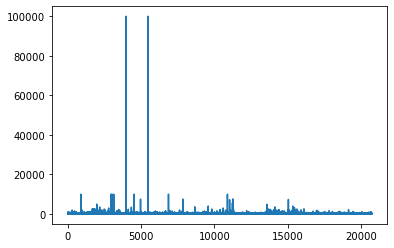

In [27]:
plt.plot(df['price'])

We see that prices contain outliers, let's delete them:

In [28]:
mean_price = df['price'].mean()
std_price = df['price'].std()

outliers = df['price'] > mean_price + 2 * std_price

df = df[~outliers]


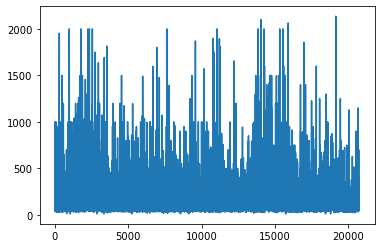

In [29]:
plt.plot(df['price'])

## Strategy 1: fill empty rating with mean

In [30]:
df.loc[df['rating'] == 'New ','rating'] = 'No rating'

In [31]:
df2 = df.copy() # hold a copy for strategy 2

mean_rating = df.loc[df['rating']!='No rating','rating'].astype(float).mean()

df.loc[df['rating']=='No rating','rating'] = mean_rating

df['rating'] = df['rating'].astype(float)

In [32]:
df.dtypes

room_type                           int64
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
rating                            float64
bedrooms                          float64
beds                                int64
baths                             float64
encoded_Bronx                       uint8
encoded_Brooklyn                    uint8
encoded_Manhattan                   uint8
encoded_Queens                      uint8
encoded_Staten Island               uint8
year                                int64
month                               int64
day                                 int64
dtype: object

We are now dealing only with numeric features. Let's look at highly correlated variables:

<AxesSubplot:>

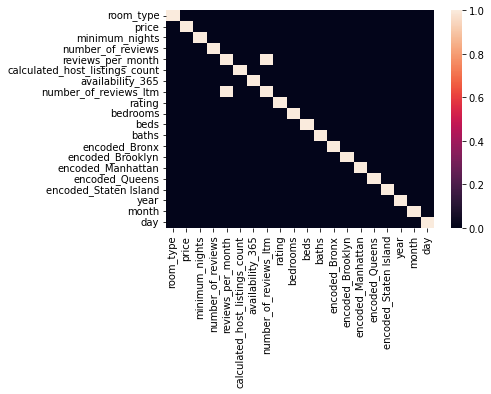

In [33]:
sb.heatmap(df.corr()>.8)

Number of reviews, as could be expected, correlates with review per month. Let's keep only the first:

In [34]:
df = df.drop(columns='reviews_per_month')

Normalize data and split them into training and test:

In [35]:
X = df.drop(columns='price').values

y = df['price'].values

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 0 ) 


In [36]:
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

Let's train linear, random forest and XGB models:

In [37]:

models = [
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor()
    
]

mse_train = []
mse_test = []
predictions = []

for model in tqdm(models,desc = 'Training models'):
    
    model.fit(X_train,y_train)
    
    predictions.append(model.predict(X_test))
    
    mse_train.append(mse(model.predict(X_train), y_train))
    
    mse_test.append(mse(model.predict(X_test), y_test))

print(" LINEAR REGRESSION:    TRAIN ERROR ", mse_train[0], "  VALIDATION ERROR    ", mse_test[0])
print(" RANDOM FOREST:    TRAIN ERROR ", mse_train[1], "  VALIDATION ERROR    ", mse_test[1])
print(" XGB:    TRAIN ERROR ", mse_train[2], "  VALIDATION ERROR    ", mse_test[2])



Training models: 100%|██████████| 3/3 [00:12<00:00,  4.09s/it]

 LINEAR REGRESSION:    TRAIN ERROR  18426.940471502985   VALIDATION ERROR     16747.339030547606
 RANDOM FOREST:    TRAIN ERROR  2092.6896504169326   VALIDATION ERROR     13382.64651162352
 XGB:    TRAIN ERROR  5132.913494225069   VALIDATION ERROR     13356.590412007245


XGB (but also random forest) seems to perform better. Let's visualize the absolute errors distribution between predictions and true values:

In [39]:

print(y_test[0:30])
print(predictions[2][0:30])


[  95. 1200.   37.   71.   50.  470.   59.   46.  153.   90.  165.   98.
   97.  130.  105.   40.  109.  200.  271.  300.   89.  495.   65.   50.
   65.  122.  105.  147.   65.  120.]
[103.2395   794.19763   30.615894  88.13074   51.204777 282.19684
  87.73967   83.3106   148.88313  168.5317   525.174     88.27621
 135.74286  149.46294  187.33197  121.87924   95.88448  212.6462
 373.43307  305.79175   93.3558   243.5887    75.28634   92.10541
 149.24124  240.35738  203.3563   116.786026  64.52799  147.73384 ]


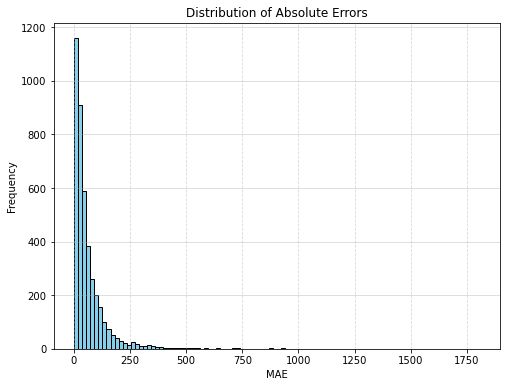

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(abs(y_test - predictions[2]), bins=100, color='skyblue', edgecolor='black')

plt.title('Distribution of Absolute Errors')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

## Strategy 2: fill empty rating using KNN

Now, we use KNN to infer the rating based on other features, and then use such ratings in the dataset

In [57]:
from sklearn.neighbors import KNeighborsRegressor

df2_training = df2[df2['rating']!='No rating']
df2_training['rating'] = df2_training['rating'].astype(float)
X_train_KNN = df2_training.drop(columns=['rating'])  
y_train_KNN = df2_training['rating']

knn_model = KNeighborsRegressor(n_neighbors=5)  
knn_model.fit(X_train_KNN, y_train_KNN)

df2_test = df2[df2['rating']=='No rating']

X_predict = df2_test.drop(columns=['rating'])

predicted_rating = knn_model.predict(X_predict)

C:\Users\Fabrizio\AppData\Local\Temp\ipykernel_1192\2626598171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_training['rating'] = df2_training['rating'].astype(float)


In [61]:
df2.loc[df2['rating']=='No rating','rating'] = predicted_rating

Let's do the same as before:

In [62]:
df2 = df2.drop(columns='reviews_per_month')

X = df2.drop(columns='price').values

y = df2['price'].values

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 0 ) 

sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 


models = [
    LinearRegression(),
    RandomForestRegressor(),
    XGBRegressor()
    
]

mse_train = []
mse_test = []
predictions = []

for model in tqdm(models,desc = 'Training models'):
    
    model.fit(X_train,y_train)
    
    predictions.append(model.predict(X_test))
    
    mse_train.append(mse(model.predict(X_train), y_train))
    
    mse_test.append(mse(model.predict(X_test), y_test))

print(" LINEAR REGRESSION:    TRAIN ERROR ", mse_train[0], "  VALIDATION ERROR    ", mse_test[0])
print(" RANDOM FOREST:    TRAIN ERROR ", mse_train[1], "  VALIDATION ERROR    ", mse_test[1])
print(" XGB:    TRAIN ERROR ", mse_train[2], "  VALIDATION ERROR    ", mse_test[2])



Training models: 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]

 LINEAR REGRESSION:    TRAIN ERROR  18337.472295836356   VALIDATION ERROR     16668.98720662237
 RANDOM FOREST:    TRAIN ERROR  2105.5339962553603   VALIDATION ERROR     13685.910170241546
 XGB:    TRAIN ERROR  5015.357378977696   VALIDATION ERROR     12753.426357347967


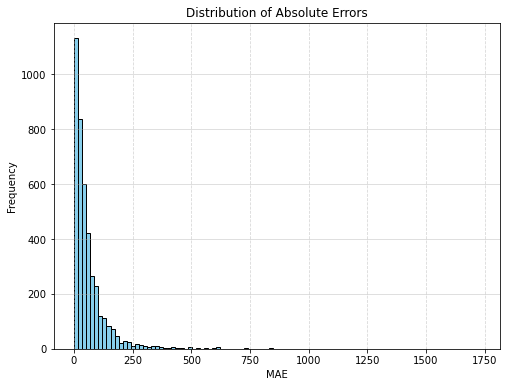

In [63]:
plt.figure(figsize=(8, 6))
plt.hist(abs(y_test - predictions[2]), bins=100, color='skyblue', edgecolor='black')

plt.title('Distribution of Absolute Errors')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

**Conclusion**: the best model, XGB, performs slightly better in the second scenario